# Harmony

## Parameters

In [1]:
analysis_name = 'harmony'
n_pcs = 20
n_neighbors = 25
resolution = 1
gene_list_path = 'input/Seurat_HVGs.txt'
n_top_genes = 2000

## Import

In [2]:
import anndata
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from harmonypy import run_harmony
import numpy as np
from sklearn.metrics import pairwise_distances

## Load Data

In [3]:
mch_adata = anndata.read_h5ad('input/mch_adata.h5ad')
mch_adata

AnnData object with n_obs × n_vars = 3898 × 46055
    obs: 'Technology', 'Brain Region', 'AD Index', 'Total Methylome Reads', 'Overall Adjusted mCG%', 'Overall Adjusted mCH%', 'Overall mCCC%', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'MajorCluster', 'ClusterAnno', 'MajorType', 'SubClusterInternalID', 'subumap_0', 'subumap_1', 'subtsne_0', 'subtsne_1', 'SubMarker', 'SubClusterAnno', 'MajorMarker', 'Individual ID', 'Individual Label', 'Individual Age', 'm3c_cluster', 'cell_id'

In [4]:
rna_adata = anndata.read_h5ad('input/rna_adata.h5ad')
rna_adata

AnnData object with n_obs × n_vars = 3898 × 60606
    obs: 'Technology', 'Brain Region', 'AD Index', 'Total Methylome Reads', 'Overall Adjusted mCG%', 'Overall Adjusted mCH%', 'Overall mCCC%', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'MajorCluster', 'ClusterAnno', 'MajorType', 'SubClusterInternalID', 'subumap_0', 'subumap_1', 'subtsne_0', 'subtsne_1', 'SubMarker', 'SubClusterAnno', 'MajorMarker', 'Individual ID', 'Individual Label', 'Individual Age', 'm3c_cluster', 'cell_id'

In [5]:
cell_total_rna = pd.Series(rna_adata.X.sum(axis=1), index=rna_adata.obs_names)
cell_total_rna.index=cell_total_rna.index.str[:-4]

## Reverse mCH data
- mCH fraction negative correlation with RNA expression, reverse the mCH data to turn to positive correlation.

In [6]:
mch_adata.X = mch_adata.X.max() - mch_adata.X

## Feature Selection

In [7]:
use_genes = pd.read_csv(gene_list_path, index_col=0, header=None).index[:n_top_genes]
use_genes = use_genes.str.replace('-', '_')

## RNA preprocessing

In [8]:
sc.pp.filter_genes(rna_adata, min_cells=20)
sc.pp.normalize_per_cell(rna_adata)
sc.pp.log1p(rna_adata)

In [9]:
rna_adata = rna_adata[:, rna_adata.var_names.isin(use_genes)].copy()
mch_adata = mch_adata[:, mch_adata.var_names.isin(use_genes)].copy()

## Scale

In [10]:
sc.pp.scale(mch_adata)
sc.pp.scale(rna_adata)

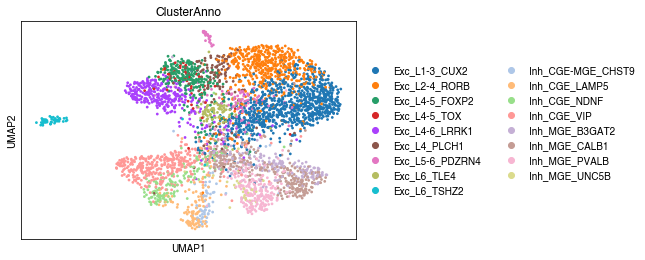

In [11]:
sc.pp.pca(rna_adata)
sc.pp.neighbors(rna_adata)
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata, color='ClusterAnno')

## Concatenate 

In [12]:
adata = mch_adata.concatenate(rna_adata, index_unique=None)
adata.obs['batch'] = adata.obs['batch'].map({'0': 'mC', '1': 'RNA'})
# adata.obs['batch'] = adata.obs['batch'].astype(str) + adata.obs.index.str.split('_').str[0]
adata

AnnData object with n_obs × n_vars = 7796 × 1659
    obs: 'Technology', 'Brain Region', 'AD Index', 'Total Methylome Reads', 'Overall Adjusted mCG%', 'Overall Adjusted mCH%', 'Overall mCCC%', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'MajorCluster', 'ClusterAnno', 'MajorType', 'SubClusterInternalID', 'subumap_0', 'subumap_1', 'subtsne_0', 'subtsne_1', 'SubMarker', 'SubClusterAnno', 'MajorMarker', 'Individual ID', 'Individual Label', 'Individual Age', 'm3c_cluster', 'cell_id', 'n_counts', 'batch'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'n_cells-1'

## PCA before harmony

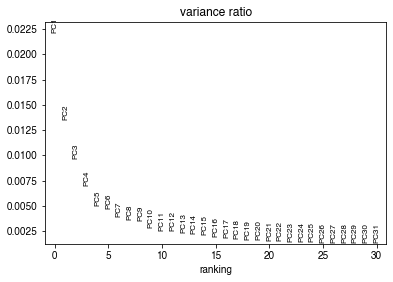

Will use 20 PCs.


In [13]:
sc.pp.pca(adata, n_comps=100)
sc.pl.pca_variance_ratio(adata)

# determine n_pcs automatically via ks_test
if n_pcs == 'auto':
    p_cutoff = 0.1
    for i in range(adata.obsm['X_pca'].shape[1] - 1):
        cur_pc = adata.obsm['X_pca'][:, i]
        next_pc = adata.obsm['X_pca'][:, i + 1]
        p = ks_2samp(cur_pc, next_pc).pvalue
        if p > p_cutoff:
            break
    n_pcs = i + 1
print(f'Will use {n_pcs} PCs.')

## Harmony correction on PCs

In [14]:
ho = run_harmony(adata.obsm['X_pca'][:, :n_pcs],
                 meta_data=adata.obs,
                 vars_use='batch',
                 random_state=0)
adata.obsm['X_pca'] = ho.Z_corr.T

2021-02-10 11:54:14,155 - harmonypy - INFO - Iteration 1 of 10
2021-02-10 11:54:17,393 - harmonypy - INFO - Iteration 2 of 10
2021-02-10 11:54:20,465 - harmonypy - INFO - Iteration 3 of 10
2021-02-10 11:54:23,636 - harmonypy - INFO - Iteration 4 of 10
2021-02-10 11:54:26,713 - harmonypy - INFO - Iteration 5 of 10
2021-02-10 11:54:29,777 - harmonypy - INFO - Iteration 6 of 10
2021-02-10 11:54:32,851 - harmonypy - INFO - Converged after 6 iterations


## Plot PCs

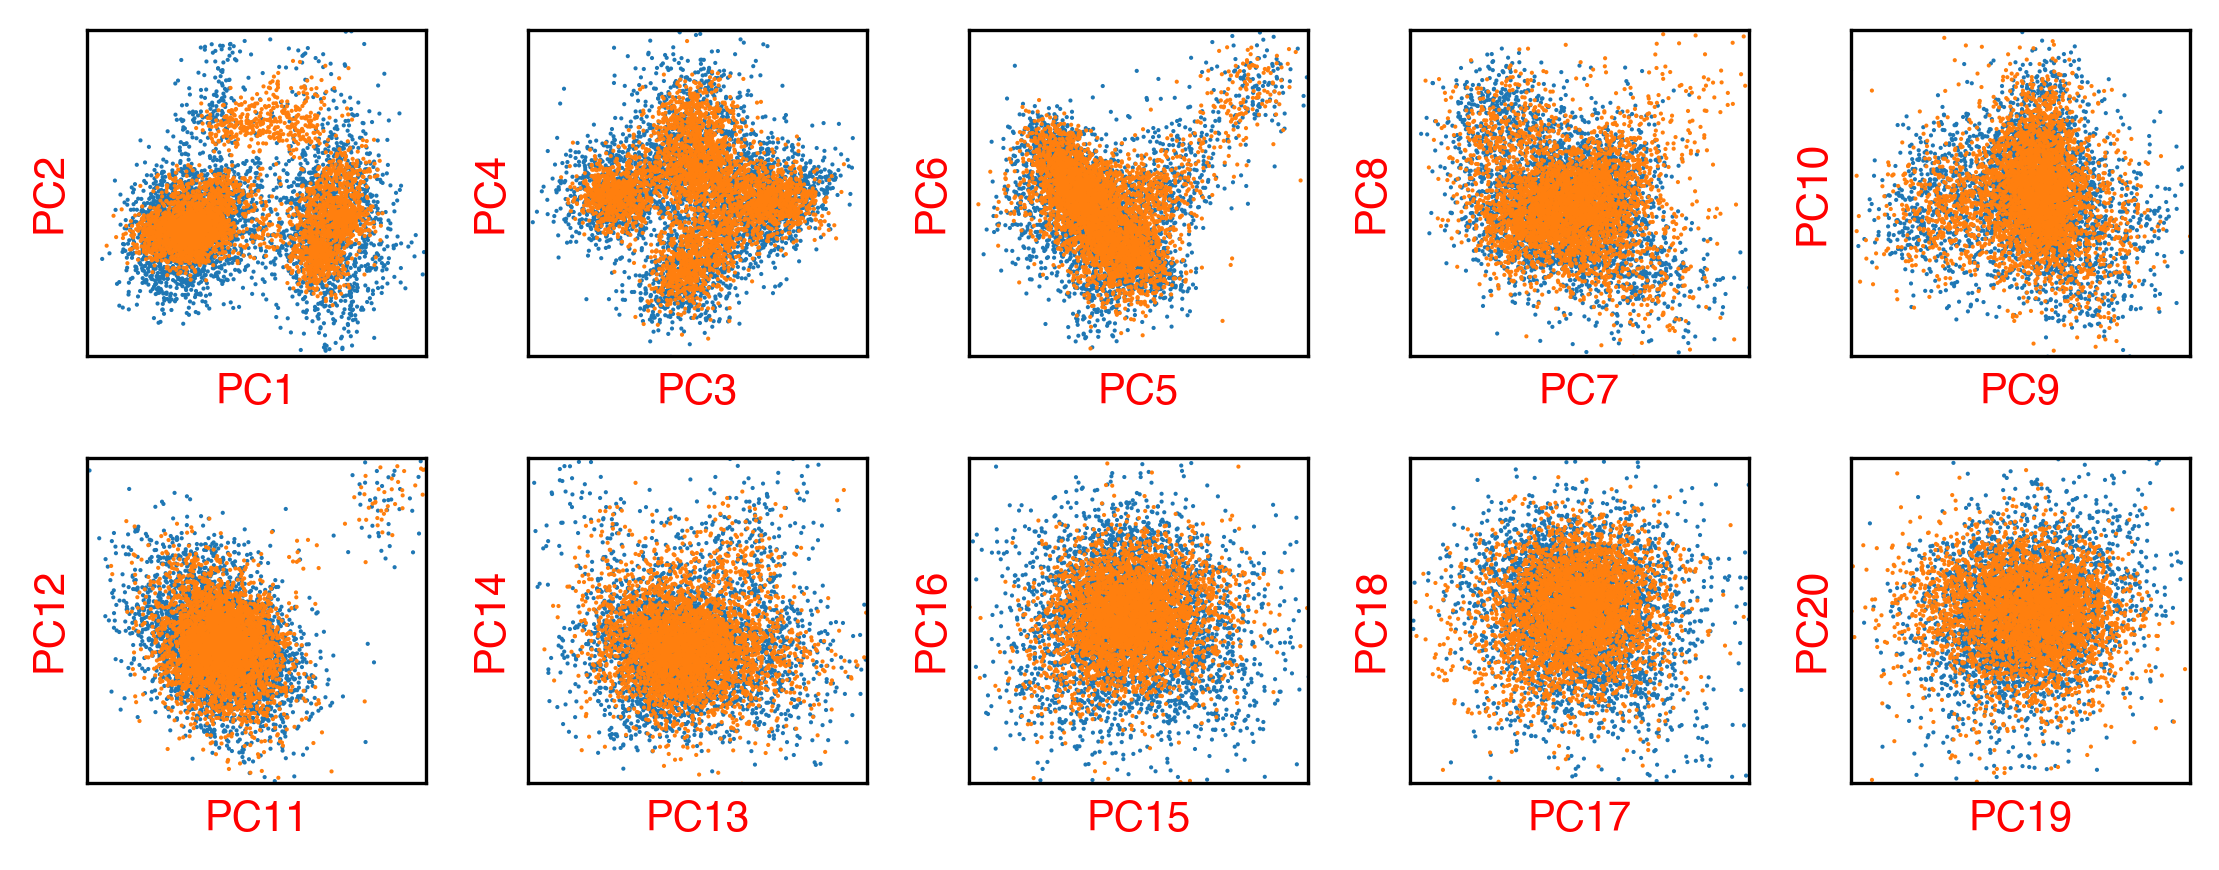

In [15]:
ncols, nrows = 5, 2
hue = 'batch'
fig, axes = plt.subplots(figsize=(ncols * 1.5, nrows * 1.5),
                             nrows=nrows,
                             ncols=ncols,
                             dpi=300)
for i, ax in enumerate(axes.ravel()):
    _x = i * 2
    _y = i * 2 + 1
    _plot_data = pd.DataFrame({
        f'PC{_x + 1}': adata.obsm['X_pca'][:, _x],
        f'PC{_y + 1}': adata.obsm['X_pca'][:, _y]
    }, index=adata.obs_names)
    _plot_data[hue] = adata.obs[hue]
    sns.scatterplot(ax=ax,
                    data=_plot_data,
                    x=f'PC{_x + 1}',
                    y=f'PC{_y + 1}',
                    hue=hue,
                    s=1,
                    linewidth=0,
                    legend=None)
    # adjust axis
    xmin, xmax = _plot_data[f'PC{_x + 1}'].quantile([0.01, 0.99]).tolist()
    delta = (xmax - xmin) * 0.2
    xmin -= delta
    xmax += delta
    ymin, ymax = _plot_data[f'PC{_y + 1}'].quantile([0.01, 0.99]).tolist()
    delta = (ymax - ymin) * 0.2
    ymin -= delta
    ymax += delta
    ax.set(xticks=[], yticks=[], xlim=(xmin, xmax), ylim=(ymin, ymax))
    if _x + 1 <= n_pcs:
        ax.set_xlabel(f'PC{_x + 1}', color='red')
    if _y + 1 <= n_pcs:
        ax.set_ylabel(f'PC{_y + 1}', color='red')
fig.tight_layout() 

## Clustering

In [16]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=20)
#sc.tl.leiden(adata, resolution=resolution)

## Embedding

In [17]:
sc.tl.umap(adata)
adata.obs['umap_0'] = adata.obsm['X_umap'][:, 0]
adata.obs['umap_1'] = adata.obsm['X_umap'][:, 1]

## Plotting

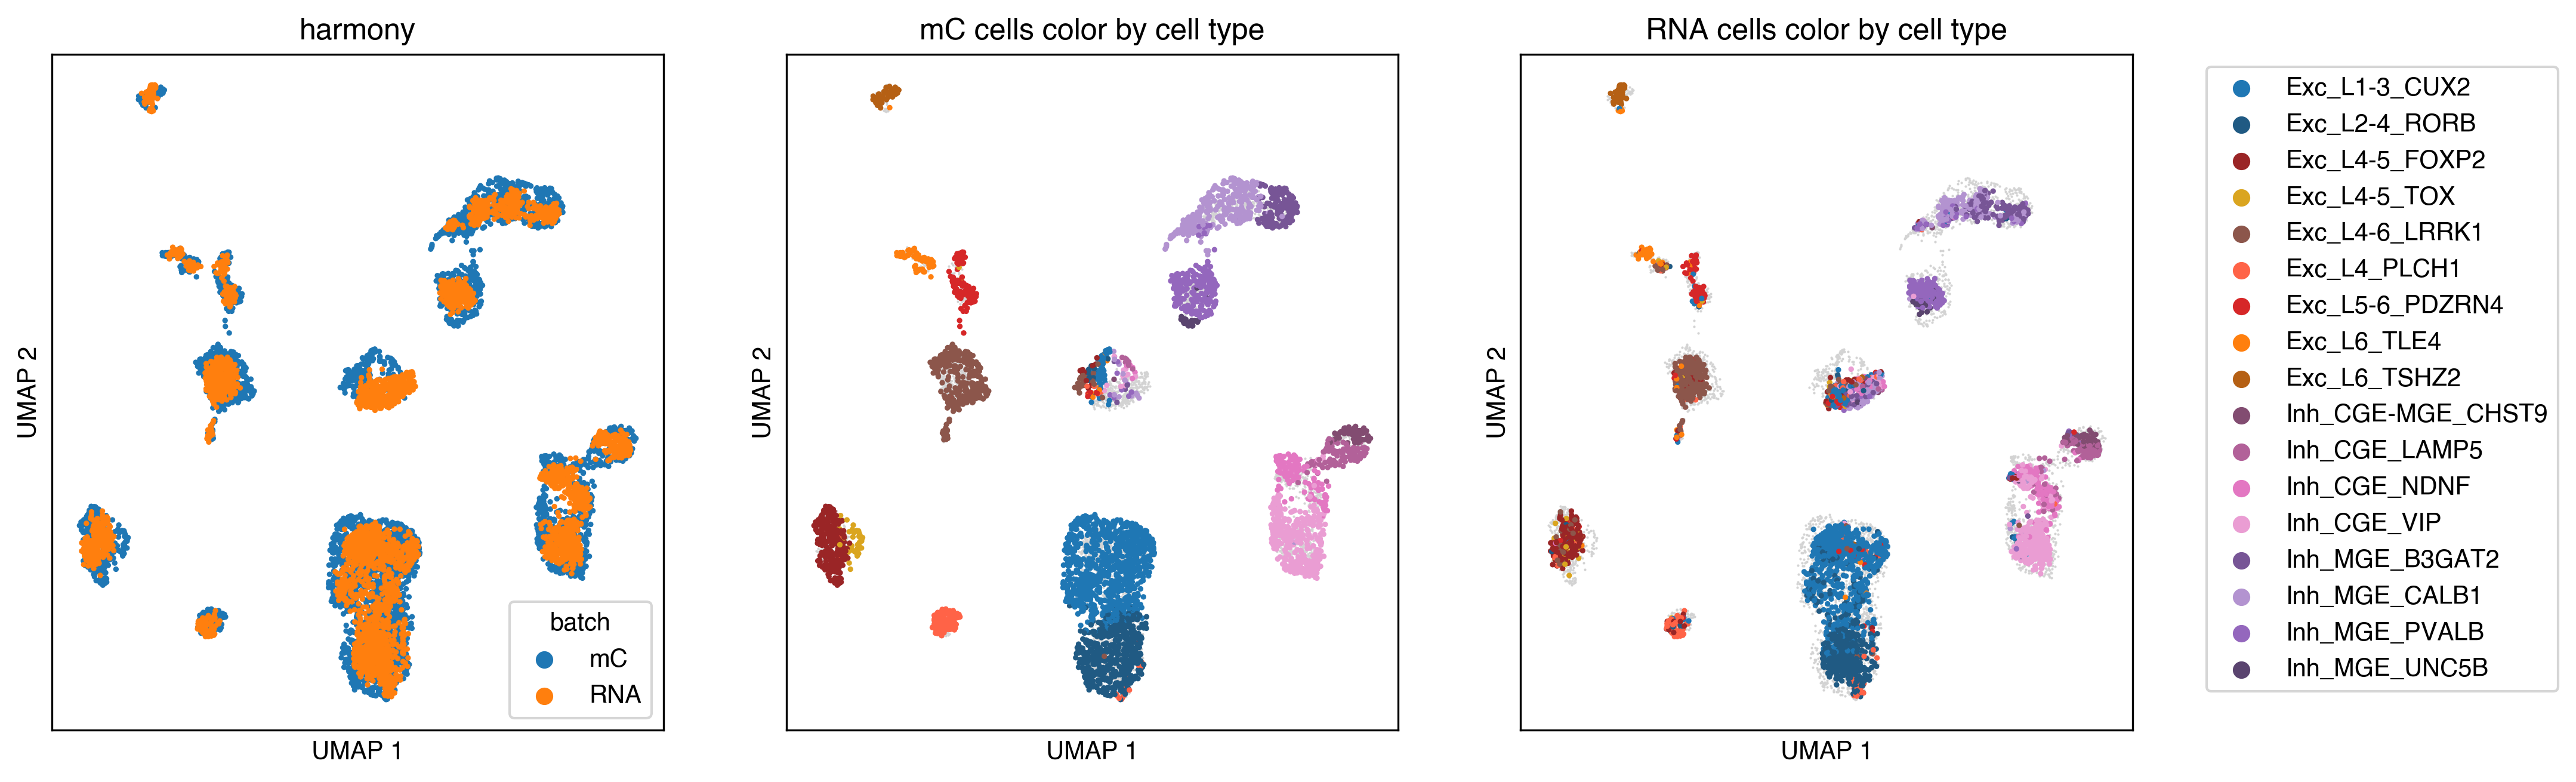

In [18]:
fig, axes = plt.subplots(figsize=(15, 5), dpi=300, ncols=3)
palette = {
    "Exc_L1-3_CUX2": "#1f77b4",
    "Exc_L2-4_RORB": "#205a83",
    "Exc_L4_PLCH1": "#ff6347",
    "Exc_L4-5_FOXP2": "#9a2526",
    "Exc_L4-5_TOX": "#daa520",
    "Exc_L4-6_LRRK1": "#8c564b",
    "Exc_L5-6_PDZRN4": "#d62728",
    "Exc_L6_TLE4": "#ff7f0e",
    "Exc_L6_TSHZ2": "#b56014",
    "Inh_MGE_CALB1": "#b393d0",
    "Inh_MGE_B3GAT2": "#775596",
    "Inh_MGE_PVALB": "#9467bd",
    "Inh_MGE_UNC5B": "#5a446f",
    "Inh_CGE_VIP": "#ea9dd3",
    "Inh_CGE_NDNF": "#e377c2",
    "Inh_CGE_LAMP5": "#b26199",
    "Inh_CGE-MGE_CHST9": "#824c71",
    "NonN_Astro_FGF3R": "#298029",
    "NonN_Oligo_MBP": "#2ca02c",
    "NonN_Micro-Endo_TYROBP": "#266026",
    "Outlier": "#b2b2b2"
}
ax = axes[0]
sns.scatterplot(ax=ax,
                data=adata.obs,
                x='umap_0',
                y='umap_1',
                s=5,
                linewidth=0,
                hue='batch')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2', title=analysis_name)

ax = axes[1]
sns.scatterplot(ax=ax,
                data=adata.obs[adata.obs['batch'] == 'mC'],
                x='umap_0',
                y='umap_1',
                s=5,
                linewidth=0,
                hue='ClusterAnno',
                palette=palette, legend=None)
sns.scatterplot(ax=ax,
                data=adata.obs[adata.obs['batch'] == 'RNA'],
                x='umap_0',
                y='umap_1',
                s=1,
                linewidth=0,
                color='lightgray', 
                zorder=0)
ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2',
       xlim=xlim, ylim=ylim, title='mC cells color by cell type')

ax = axes[2]
sns.scatterplot(ax=ax,
                data=adata.obs[adata.obs['batch'] == 'RNA'],
                x='umap_0',
                y='umap_1',
                s=5,
                linewidth=0,
                hue='ClusterAnno',
                palette=palette)
sns.scatterplot(ax=ax,
                data=adata.obs[adata.obs['batch'] == 'mC'],
                x='umap_0',
                y='umap_1',
                s=1,
                linewidth=0,
                color='lightgray', 
                zorder=0)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2',
       xlim=xlim, ylim=ylim, title='RNA cells color by cell type')

pass

## Save

In [19]:
hvg_type = gene_list_path.split('/')[-1][:-4]
adata.write_h5ad(f'{analysis_name}.{hvg_type}.{n_top_genes}hvg.h5ad')

... storing 'cell_id' as categorical
